In [6]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, balanced_accuracy_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

X = pd.read_excel("breast_cancer_sans_diag.xlsx",sheet_name=0,header=0)

print(X.shape)

T = X.describe()  #on représente les statistiques descriptives
print(T)

(569, 31)
                 id  radius_mean  texture_mean  perimeter_mean    area_mean  \
count  5.690000e+02   569.000000    569.000000      569.000000   569.000000   
mean   3.037183e+07    14.127292     19.289649       91.969033   654.889104   
std    1.250206e+08     3.524049      4.301036       24.298981   351.914129   
min    8.670000e+03     6.981000      9.710000       43.790000   143.500000   
25%    8.692180e+05    11.700000     16.170000       75.170000   420.300000   
50%    9.060240e+05    13.370000     18.840000       86.240000   551.100000   
75%    8.813129e+06    15.780000     21.800000      104.100000   782.700000   
max    9.113205e+08    28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.0

In [7]:
X_numeric = X.select_dtypes(include=['number'])

print(X_numeric.mean()) 
print(X_numeric.var())

id                         3.037183e+07
radius_mean                1.412729e+01
texture_mean               1.928965e+01
perimeter_mean             9.196903e+01
area_mean                  6.548891e+02
smoothness_mean            9.636028e-02
compactness_mean           1.043410e-01
concavity_mean             8.879932e-02
concave points_mean        4.891915e-02
symmetry_mean              1.811619e-01
fractal_dimension_mean     6.279761e-02
radius_se                  4.051721e-01
texture_se                 1.216853e+00
perimeter_se               2.866059e+00
area_se                    4.033708e+01
smoothness_se              7.040979e-03
compactness_se             2.547814e-02
concavity_se               3.189372e-02
concave points_se          1.179614e-02
symmetry_se                2.054230e-02
fractal_dimension_se       3.794904e-03
radius_worst               1.626919e+01
texture_worst              2.567722e+01
perimeter_worst            1.072612e+02
area_worst                 8.805831e+02


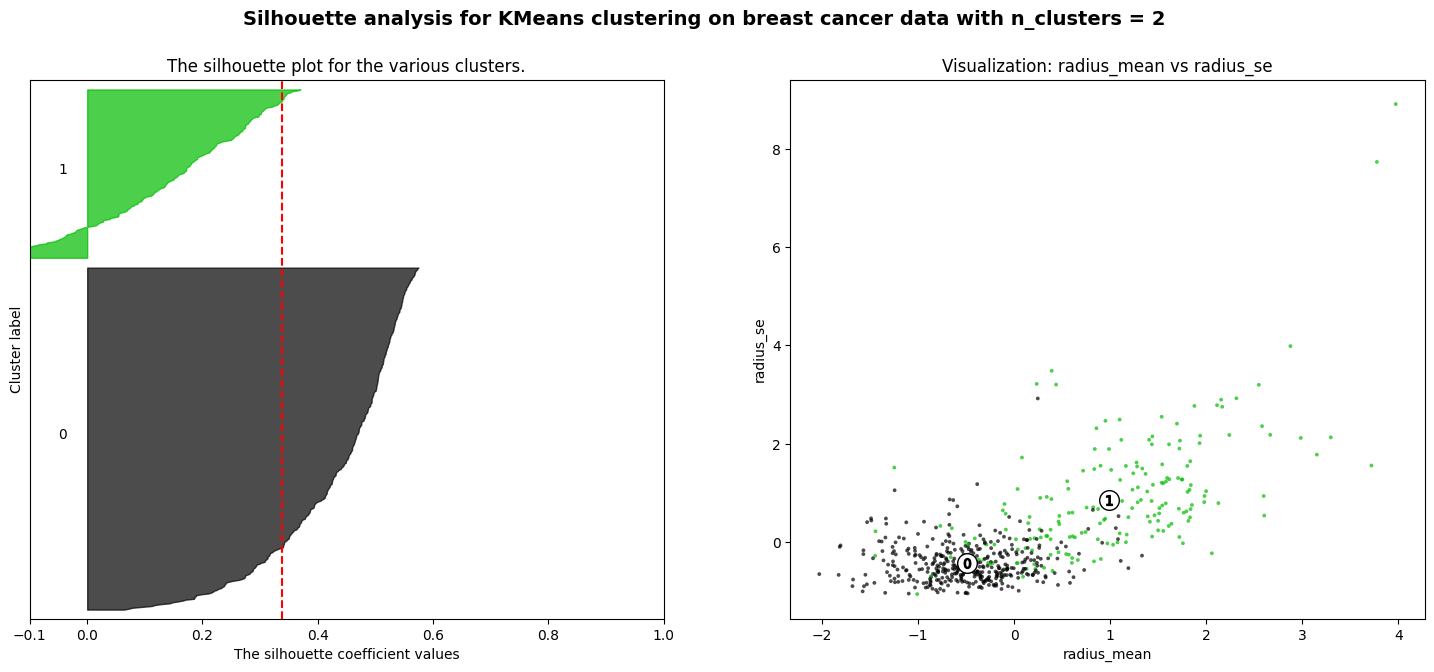

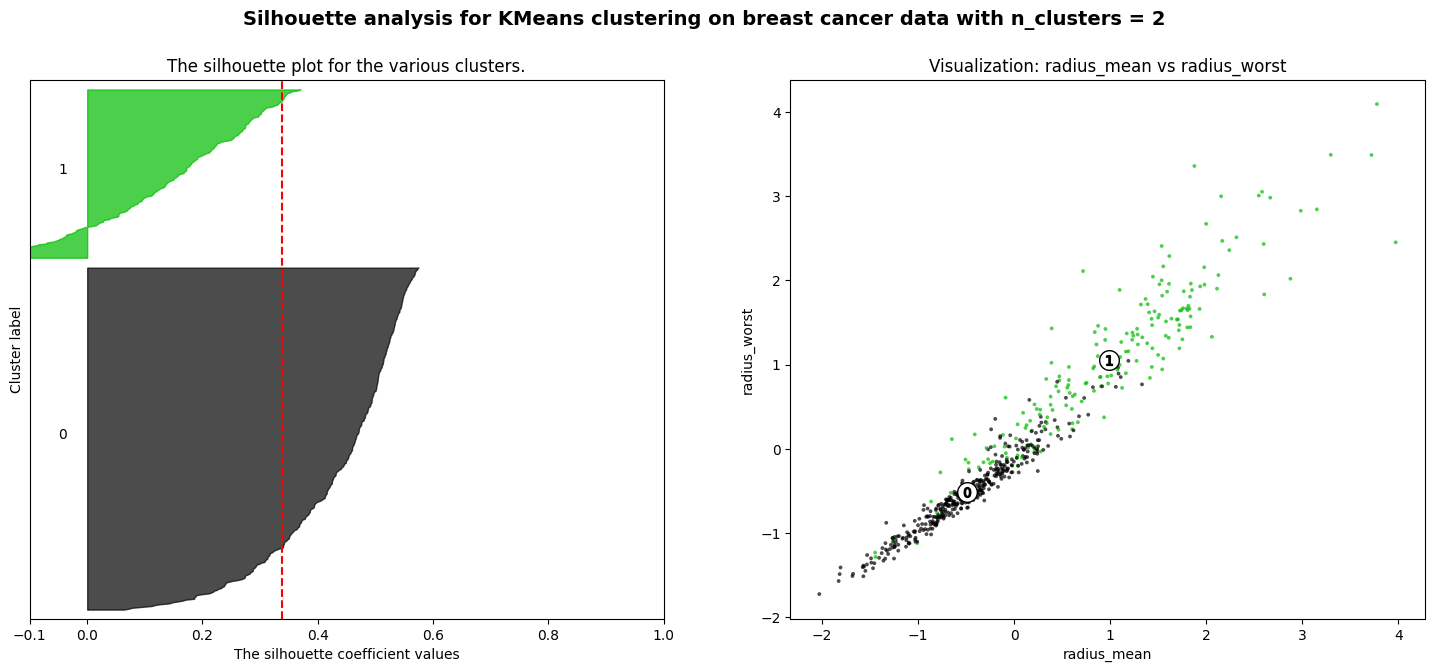

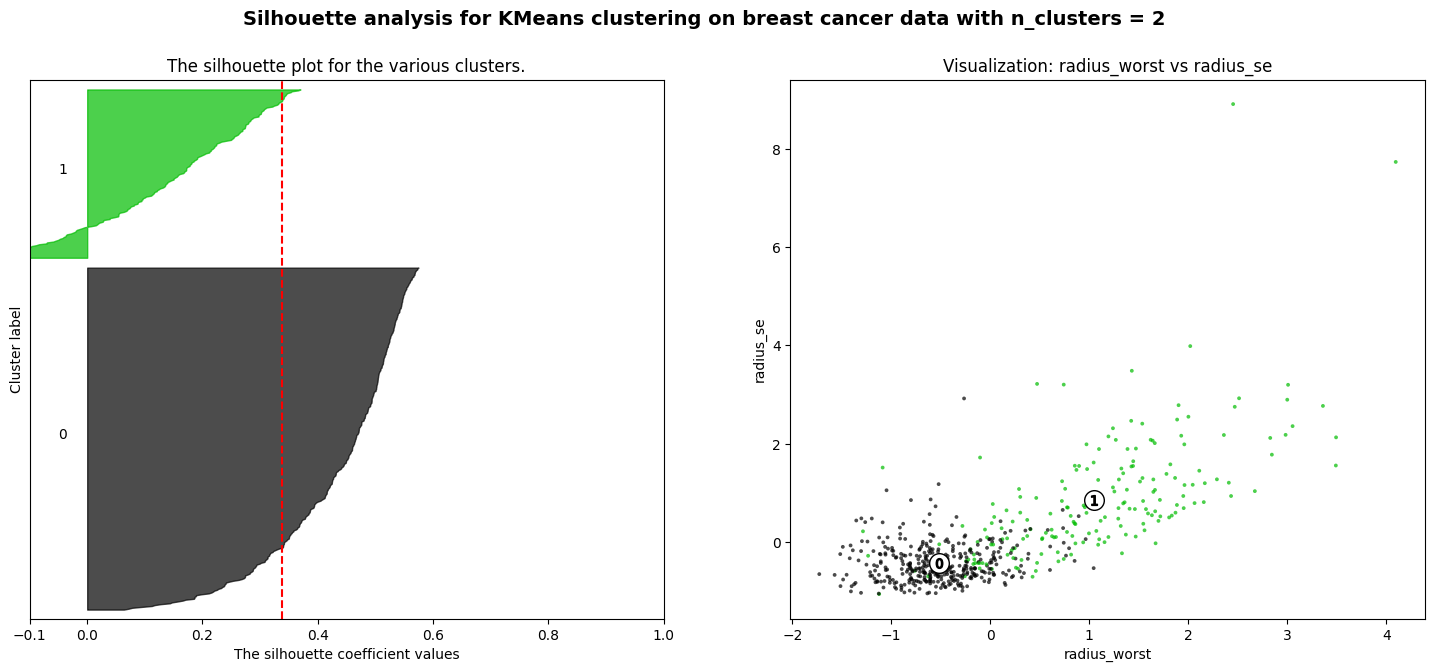

In [29]:
# Standardisation des données (important pour KMeans)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)


# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(X_scaled) + (2 + 1) * 10])

# Initialize the clusterer with n_clusters value and a random generator
# seed of 10 for reproducibility.
clusterer = KMeans(n_clusters=2, random_state=10)
cluster_labels = clusterer.fit_predict(X_scaled)

# The silhouette_score gives the average value for all the samples.
silhouette_avg = silhouette_score(X_scaled, cluster_labels)


# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)

y_lower = 10
for i in range(2):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / 2)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
# Sélection des colonnes mean et std 
mean_cols = [col for col in X_numeric.columns if 'mean' in col.lower()]
std_cols = [col for col in X_numeric.columns if 'se' in col.lower()]
worst_cols = [col for col in X_numeric.columns if 'worst' in col.lower()]

if len(mean_cols) > 0 and len(std_cols) > 0:
    X_vis = X_numeric[[mean_cols[0], std_cols[0]]].values
    scaler_vis = StandardScaler()
    X_vis_scaled = scaler_vis.fit_transform(X_vis)
    
    colors = cm.nipy_spectral(cluster_labels.astype(float) / 2)
    ax2.scatter(
        X_vis_scaled[:, 0], X_vis_scaled[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters - transformer les centres en 2D
    centers = clusterer.cluster_centers_
    # Extraire les indices des colonnes mean et std dans X_scaled
    mean_idx = X_numeric.columns.get_loc(mean_cols[0])
    std_idx = X_numeric.columns.get_loc(std_cols[0])
    centers_2d = centers[:, [mean_idx, std_idx]]
    
    # Draw white circles at cluster centers
    ax2.scatter(
        centers_2d[:, 0],
        centers_2d[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers_2d):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title(f"Visualization: {mean_cols[0]} vs {std_cols[0]}")
    ax2.set_xlabel(mean_cols[0])
    ax2.set_ylabel(std_cols[0])

plt.suptitle(
    "Silhouette analysis for KMeans clustering on breast cancer data with n_clusters = %d"
    % 2,
    fontsize=14,
    fontweight="bold",
)
plt.show()

# FIGURE 2
fig2, (ax1_2, ax2_2) = plt.subplots(1, 2)
fig2.set_size_inches(18, 7)

ax1_2.set_xlim([-0.1, 1])
ax1_2.set_ylim([0, len(X_scaled) + (2 + 1) * 10])

y_lower = 10
for i in range(2):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / 2)
    ax1_2.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )
    ax1_2.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

ax1_2.set_title("The silhouette plot for the various clusters.")
ax1_2.set_xlabel("The silhouette coefficient values")
ax1_2.set_ylabel("Cluster label")
ax1_2.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1_2.set_yticks([])
ax1_2.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

if len(mean_cols) > 0 and len(worst_cols) > 0:
    X_vis = X_numeric[[mean_cols[0], worst_cols[0]]].values
    scaler_vis = StandardScaler()
    X_vis_scaled = scaler_vis.fit_transform(X_vis)
    
    colors = cm.nipy_spectral(cluster_labels.astype(float) / 2)
    ax2_2.scatter(
        X_vis_scaled[:, 0], X_vis_scaled[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    centers = clusterer.cluster_centers_
    mean_idx = X_numeric.columns.get_loc(mean_cols[0])
    worst_idx = X_numeric.columns.get_loc(worst_cols[0])
    centers_2d = centers[:, [mean_idx, worst_idx]]
    
    ax2_2.scatter(
        centers_2d[:, 0],
        centers_2d[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers_2d):
        ax2_2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2_2.set_title(f"Visualization: {mean_cols[0]} vs {worst_cols[0]}")
    ax2_2.set_xlabel(mean_cols[0])
    ax2_2.set_ylabel(worst_cols[0])

plt.suptitle(
    "Silhouette analysis for KMeans clustering on breast cancer data with n_clusters = %d"
    % 2,
    fontsize=14,
    fontweight="bold",
)
plt.show()

# FIGURE 3
fig3, (ax1_3, ax2_3) = plt.subplots(1, 2)
fig3.set_size_inches(18, 7)

ax1_3.set_xlim([-0.1, 1])
ax1_3.set_ylim([0, len(X_scaled) + (2 + 1) * 10])

y_lower = 10
for i in range(2):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / 2)
    ax1_3.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )
    ax1_3.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

ax1_3.set_title("The silhouette plot for the various clusters.")
ax1_3.set_xlabel("The silhouette coefficient values")
ax1_3.set_ylabel("Cluster label")
ax1_3.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1_3.set_yticks([])
ax1_3.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

if len(worst_cols) > 0 and len(std_cols) > 0:
    X_vis = X_numeric[[worst_cols[0], std_cols[0]]].values
    scaler_vis = StandardScaler()
    X_vis_scaled = scaler_vis.fit_transform(X_vis)
    
    colors = cm.nipy_spectral(cluster_labels.astype(float) / 2)
    ax2_3.scatter(
        X_vis_scaled[:, 0], X_vis_scaled[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    centers = clusterer.cluster_centers_
    worst_idx = X_numeric.columns.get_loc(worst_cols[0])
    std_idx = X_numeric.columns.get_loc(std_cols[0])
    centers_2d = centers[:, [worst_idx, std_idx]]
    
    ax2_3.scatter(
        centers_2d[:, 0],
        centers_2d[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers_2d):
        ax2_3.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2_3.set_title(f"Visualization: {worst_cols[0]} vs {std_cols[0]}")
    ax2_3.set_xlabel(worst_cols[0])
    ax2_3.set_ylabel(std_cols[0])

plt.suptitle(
    "Silhouette analysis for KMeans clustering on breast cancer data with n_clusters = %d"
    % 2,
    fontsize=14,
    fontweight="bold",
)
plt.show()

Visualisation à l'aide de l'ACP comme sur l'exemple de : https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

On doit visualiser nos caractéristiques (mean, std, worst)